# Training a Neural Network on MNIST dataset on a lower dimensionl data using PCA

In [274]:
import os
import gzip
import pickle
import numpy as np
from skimage.feature import hog
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

### MNIST Dataset
MNIST Dataset consists of 60000 images of hand written digits from 0-9. It is split into a traning set consisting of 50000 images and a test set consisting of 10000 images. Each image is a grayscale image with a dimension of 28 x 28.

In [296]:
# image size and the number of training and testing samples
image_size = 28
num_train = 50000
num_test = 10000

In [297]:
# Read the training data
f = gzip.open(os.path.join('data', 'train-images-idx3-ubyte.gz'),'r')
f.read(16)
buf = f.read(image_size * image_size * num_train)
train_data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
train_data = train_data.reshape(num_train, image_size, image_size)
f.close()

In [298]:
# Read the testing data
f = gzip.open(os.path.join('data', 't10k-images-idx3-ubyte.gz'),'r')
f.read(16)
buf = f.read(image_size * image_size * num_test)
test_data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
test_data = test_data.reshape(num_test, image_size, image_size)
f.close()

In [299]:
# Read the training labels
f = gzip.open(os.path.join('data', 'train-labels-idx1-ubyte.gz'),'r')
f.read(8)
buf = f.read(num_train)
train_labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
train_labels = train_labels.reshape(num_train, )
f.close()

In [300]:
# Read the test labels
f = gzip.open(os.path.join('data', 't10k-labels-idx1-ubyte.gz'),'r')
f.read(8)
buf = f.read(num_test)
test_labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
test_labels = test_labels.reshape(num_test,)
f.close()

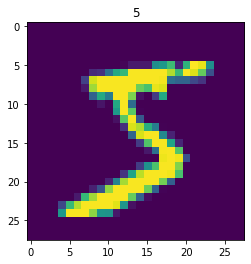

In [301]:
# Display the first sample from the training data
image = np.asarray(train_data[0]).squeeze()
plt.imshow(image)
plt.title(train_labels[0])
plt.show()

### Principal Component Analysis (PCA)
Often when we have a dataset which spans multiple dimensions, chances are high that multiple dimensions may be capturing the same information in some form or the other. 

e.g., in a hypothetical scenario, a dataset might capture distance in both miles and kilometers as two distinct features, even though they convey the same information.

**Principal Component Analysis** works by finding out the correlation between features in a n-dimensional feature space band then projecting the features to a d-dimensional orthogonal feature space, where d < n. Note that the term orthogonal is important as it ensures that the features in the d-dimensional feature space is uncorrelated. 

In [316]:
# Reshape the training and the test data
train_data = train_data.reshape(num_train, image_size * image_size)
test_data = test_data.reshape(num_test, image_size * image_size)

In [317]:
print("Before applying PCA: {}-dimensional feature space".format(train_data.shape[1]))

Before applying PCA: 784-dimensional feature space


In [318]:
# This is done to notmalize the training and the test data
scaler = StandardScaler()
scaler.fit(train_data)
train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)

In [319]:
# Initialize the PCA, here we will be reducing our feature space from 784 dimensions to 12 dimensions
pca = PCA(0.99, svd_solver='auto')
pca.fit(train_data_scaled)
train_features = pca.transform(train_data_scaled)
test_features = pca.transform(test_data_scaled)

In [320]:
print("After applying PCA: {}-dimensional feature space".format(train_features.shape[1]))

After applying PCA: 540-dimensional feature space


In [321]:
clf = MLPClassifier(solver='adam', 
                    activation='relu', 
                    alpha=.0001, 
                    hidden_layer_sizes=(512, 256, 128, 10), 
                    random_state=1, 
                    max_iter=200)

In [322]:
clf.fit(train_features, train_labels)

MLPClassifier(hidden_layer_sizes=(512, 256, 128, 10), random_state=1)

In [323]:
pred = clf.predict(train_features)
train_accuracy = np.mean(pred == train_labels)

In [324]:
pred = clf.predict(test_features)
test_accuracy = np.mean(pred == test_labels)

In [325]:
print("Training accuracy: {}".format(train_accuracy))
print("Testing accuracy: {}".format(test_accuracy))

Training accuracy: 0.9984
Testing accuracy: 0.9721


In [326]:
num_wrong_cls = np.sum(pred != test_labels)
print("Number of images incorrectly classified: {}".format(num_wrong_cls))

Number of images incorrectly classified: 279


In [327]:
# Save the weights file to disc
pickle.dump(clf, open("mnist_pca.sav", 'wb'))

In [328]:
incorrect_pred = pred != test_labels
incorrect_idx = np.where(incorrect_pred == True)
top_five = incorrect_idx[0][:5]

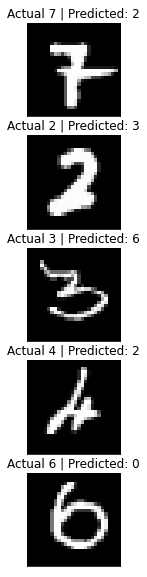

In [329]:
plt.figure(figsize = (10, 10))
for i, idx in enumerate(top_five):
    plt.subplot(5,1,i + 1),plt.imshow(test_data[idx].reshape(image_size, image_size),cmap = 'gray')
    plt.title('Actual {} | Predicted: {}'.format(test_labels[idx], pred[idx])), plt.xticks([]), plt.yticks([])
plt.show()